In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import random
import copy
from PIL import Image

In [2]:
# Configuración del dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [ ]:
def copiar_imagenes(origen, destino, cantidad, prefijo):
    """Copia 'cantidad' imágenes aleatorias añadiendo un prefijo al nombre"""
    if not origen.exists():
        print(f"Error: No encuentro la carpeta de origen: {origen}")
        print("Revisa si el nombre tiene mayúsculas/minúsculas diferentes.")
        return

    # Listamos solo archivos de imagen
    archivos = [f for f in os.listdir(origen) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Selección aleatoria
    if len(archivos) < cantidad:
        print(f"AVISO: En {origen} solo hay {len(archivos)} fotos. Se copiarán todas.")
        seleccion = archivos
    else:
        seleccion = random.sample(archivos, cantidad)

    # Copiado
    for archivo in seleccion:
        ruta_origen = origen / archivo
        nuevo_nombre = f"{prefijo}_{archivo}"
        ruta_destino = destino / nuevo_nombre
        shutil.copy2(ruta_origen, ruta_destino)
    
    print(f"   Copiadas {len(seleccion)} fotos desde '{origen.name}'")

# Verificación de los datos

## Train

In [3]:
# Rutas de ORIGEN (De donde sacamos las fotos)
src_mask_ok = Path("../mascarillas/Face Mask Dataset/Train/WithMask")
src_mask_no = Path("../mascarillas/Face Mask Dataset/Train/WithoutMask")

In [4]:
src_helmet_ok = Path("../cascos/train/Helmet")      
src_helmet_no = Path("../cascos/train/No Helmet")

In [5]:
dst_base = Path("datos/train")
dst_mascarilla = dst_base / "mascarilla"
dst_casco = dst_base / "casco"
dst_nada = dst_base / "nada"

In [6]:
TARGET_TOTAL = 1926
TARGET_HALF = 963

In [11]:
copiar_imagenes(src_mask_ok, dst_mascarilla, TARGET_TOTAL, "mask")

   Copiadas 1926 fotos desde 'WithMask'


In [12]:
copiar_imagenes(src_helmet_ok, dst_casco, TARGET_TOTAL, "helmet")
copiar_imagenes(src_mask_no, dst_nada, TARGET_HALF, "no_mask")
copiar_imagenes(src_helmet_no, dst_nada, TARGET_HALF, "no_helmet")

   Copiadas 1926 fotos desde 'Helmet'
   Copiadas 963 fotos desde 'WithoutMask'
   Copiadas 963 fotos desde 'No Helmet'


## Validation

In [67]:
# Rutas de ORIGEN (De donde sacamos las fotos)
src_mask_ok = Path("../mascarillas/Face Mask Dataset/Validation/WithMask")
src_mask_no = Path("../mascarillas/Face Mask Dataset/Validation/WithoutMask")

In [68]:
src_helmet_ok = Path("../cascos/valid/Helmet")      
src_helmet_no = Path("../cascos/valid/No Helmet")

In [69]:
dst_base = Path("datos/validation")
dst_mascarilla = dst_base / "mascarilla"
dst_casco = dst_base / "casco"
dst_nada = dst_base / "nada"

In [70]:
TARGET_TOTAL = 281
TARGET_HALF = 135

In [71]:
copiar_imagenes(src_mask_ok, dst_mascarilla, TARGET_TOTAL, "mask")
copiar_imagenes(src_helmet_ok, dst_casco, TARGET_TOTAL, "helmet")
copiar_imagenes(src_mask_no, dst_nada, TARGET_HALF, "no_mask")
copiar_imagenes(src_helmet_no, dst_nada, TARGET_HALF, "no_helmet")

   Copiadas 281 fotos desde 'WithMask'
   Copiadas 281 fotos desde 'Helmet'
   Copiadas 135 fotos desde 'WithoutMask'
   Copiadas 135 fotos desde 'No Helmet'


## Test

In [56]:
# Rutas de ORIGEN (De donde sacamos las fotos)
src_mask_ok = Path("../mascarillas/Face Mask Dataset/Test/WithMask")
src_mask_no = Path("../mascarillas/Face Mask Dataset/Test/WithoutMask")

In [57]:
src_helmet_ok = Path("../cascos/test/Helmet")      
src_helmet_no = Path("../cascos/test/No Helmet")

In [58]:
dst_base = Path("datos/test")
dst_mascarilla = dst_base / "mascarilla"
dst_casco = dst_base / "casco"
dst_nada = dst_base / "nada"

In [59]:
TARGET_TOTAL = 143
TARGET_HALF = 72

In [60]:
copiar_imagenes(src_mask_ok, dst_mascarilla, TARGET_TOTAL, "mask")
copiar_imagenes(src_helmet_ok, dst_casco, TARGET_TOTAL, "helmet")
copiar_imagenes(src_mask_no, dst_nada, TARGET_HALF, "no_mask")
copiar_imagenes(src_helmet_no, dst_nada, TARGET_HALF, "no_helmet")

   Copiadas 143 fotos desde 'WithMask'
   Copiadas 143 fotos desde 'Helmet'
   Copiadas 72 fotos desde 'WithoutMask'
   Copiadas 72 fotos desde 'No Helmet'


# Creación modelo

In [72]:
# Semilla para reproducibilidad (para que siempre salga igual)
torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)

In [73]:
# Definir transformaciones de datos
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(), # RECOMENDADO: Déjalo, ayuda mucho y no cuesta nada.
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Val y Test deben ser idénticos: SOLO redimensionar y normalizar (sin trucos)
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [74]:
data_dir = './datos' 

# Cargar las 3 carpetas
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

In [75]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}
class_names = image_datasets['train'].classes

In [76]:
print(f"Clases: {class_names}")
print(f"Train: {dataset_sizes['train']} | Val: {dataset_sizes['validation']} | Test: {dataset_sizes['test']}")

Clases: ['casco', 'mascarilla', 'nada']
Train: 5778 | Val: 832 | Test: 430


train
casco: 1926
mascarilla: 1926
nada: 1926
Total: 5778

validation
casco: 281
mascarilla: 281
nada: 270
Total: 832

test
casco: 143
mascarilla: 143
nada: 144
Total: 430



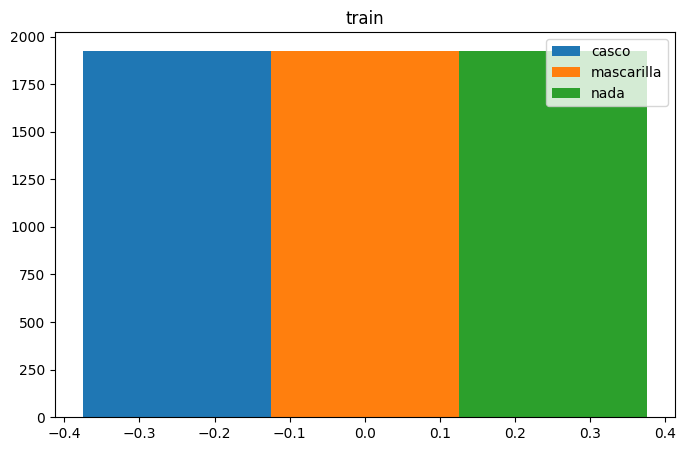

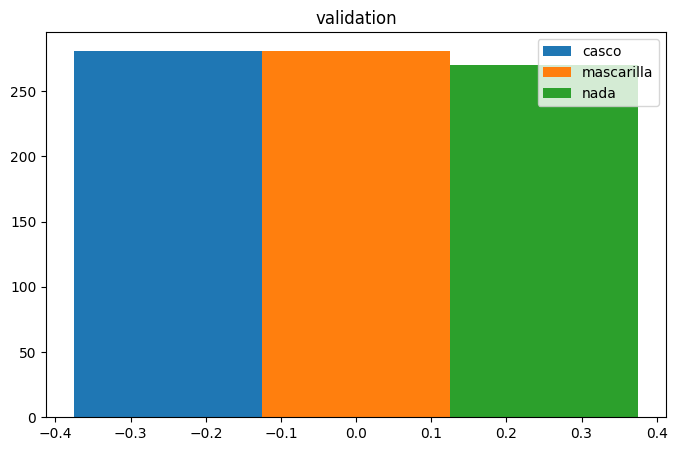

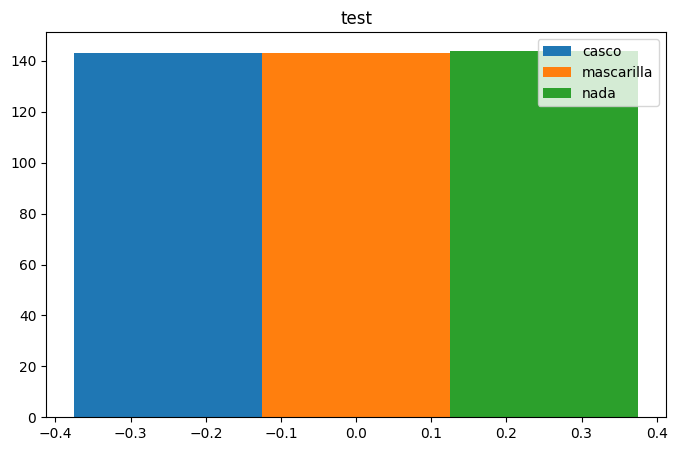

In [77]:
for fase in ["train", "validation", "test"]:
    print(f"{fase}")
    dataset = image_datasets[fase]

    targets = dataset.targets

    conteo = {clase:0 for clase in class_names}

    for index in targets:
        nombre_clase = class_names[index]
        conteo[nombre_clase] +=1

    for clase, cantidad in conteo.items():
        print(f"{clase}: {cantidad}")

    x = np.arange(1)  # posiciones para cada clase
    width = 0.25                     # ancho de cada barra
    plt.figure(figsize=(8, 5))
    plt.title(f"{fase}")
    plt.bar(x - width, conteo["casco"], width, label="casco")
    plt.bar(x , conteo["mascarilla"], width, label="mascarilla")
    plt.bar(x + width, conteo["nada"], width, label="nada")
    plt.legend()

    print(f"Total: {len(dataset)}\n")

In [78]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=0) for x in ['train', 'validation', 'test']}

In [80]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']} 
class_names = image_datasets['train'].classes

In [82]:
print(f"Clases: {class_names}")
print(f"Train: {dataset_sizes['train']} | Val: {dataset_sizes['validation']} | Test: {dataset_sizes['test']}")

Clases: ['casco', 'mascarilla', 'nada']
Train: 5778 | Val: 832 | Test: 430


In [83]:
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Manuel/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 15.4MB/s]


In [84]:
# Congelar todas las capas excepto las de batch normalization
for name, param in model.named_parameters():
    if 'bn' not in name:  # 'bn' se refiere a las capas BatchNorm
        param.requires_grad = False  # Congelar todas las demás capas
    else:
        param.requires_grad = True   # Asegurar que BatchNorm sea entrenable

# Modificar la última capa de ResNet50 para nuestro número de clases (6)
num_ftrs = model.fc.in_features

In [85]:
model.fc = nn.Sequential(
    nn.Dropout(0.2), # Ayuda a generalizar mejor
    nn.Linear(num_ftrs, len(class_names))
)

In [86]:
model = model.to(device)

In [87]:
# Definir optimizador y función de pérdida
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [100]:
def train_model(model, criterion, optimizer, num_epochs=20, patience=5, min_delta=0.005):
    """
    patience: Cuántas épocas esperar sin mejora antes de parar.
    min_delta: Cuánto debe bajar el Loss para considerarse 'mejora'. 
               0.005 significa que debe mejorar al menos un 0.5%.
    """
    since = time.time()

    # Guardaremos los pesos del mejor momento, no del último
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf') # Empezamos con pérdida infinita
    
    # Variables de control
    early_stop_counter = 0
    stop_training = False

    history = {'train_loss': [], 'train_acc': [], 'validation_loss': [], 'validation_acc': []}

    print(f"Iniciando entrenamiento con Early Stopping (Paciencia: {patience}, Delta: {min_delta})")

    for epoch in range(num_epochs):
        if stop_training:
            break

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # --- LÓGICA DE EARLY STOPPING (Solo en validación) ---
            if phase == 'validation':
                # Comprobamos si la mejora es "drástica" (mayor que min_delta)
                if epoch_loss < (best_loss - min_delta):
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_counter = 0 # Reiniciamos contador
                    print(f"  > ¡Mejora detectada! Guardando nuevo mejor modelo.")
                else:
                    early_stop_counter += 1
                    print(f"  > Sin mejora significativa. Paciencia: {early_stop_counter}/{patience}")
                    
                    if early_stop_counter >= patience:
                        print("\n🏁 EARLY STOPPING ACTIVADO: El modelo ha dejado de mejorar.")
                        stop_training = True

    time_elapsed = time.time() - since
    print(f'\nEntrenamiento completado en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Mejor Val Loss: {best_loss:.4f}')

    # IMPORTANTE: Cargamos los pesos del mejor momento, no del final
    model.load_state_dict(best_model_wts)
    return model, history

In [102]:
model_trained, history = train_model(model, criterion, optimizer, num_epochs=20, min_delta=0.0001)

Iniciando entrenamiento con Early Stopping (Paciencia: 5, Delta: 0.0001)
Epoch 1/20
----------
train Loss: 0.0356 Acc: 0.9938
validation Loss: 0.0354 Acc: 0.9952
  > ¡Mejora detectada! Guardando nuevo mejor modelo.
Epoch 2/20
----------
train Loss: 0.0370 Acc: 0.9934
validation Loss: 0.0329 Acc: 0.9964
  > ¡Mejora detectada! Guardando nuevo mejor modelo.
Epoch 3/20
----------
train Loss: 0.0373 Acc: 0.9924
validation Loss: 0.0340 Acc: 0.9940
  > Sin mejora significativa. Paciencia: 1/5
Epoch 4/20
----------
train Loss: 0.0348 Acc: 0.9941
validation Loss: 0.0319 Acc: 0.9952
  > ¡Mejora detectada! Guardando nuevo mejor modelo.
Epoch 5/20
----------
train Loss: 0.0344 Acc: 0.9943
validation Loss: 0.0330 Acc: 0.9952
  > Sin mejora significativa. Paciencia: 1/5
Epoch 6/20
----------
train Loss: 0.0319 Acc: 0.9952
validation Loss: 0.0293 Acc: 0.9940
  > ¡Mejora detectada! Guardando nuevo mejor modelo.
Epoch 7/20
----------
train Loss: 0.0360 Acc: 0.9934
validation Loss: 0.0300 Acc: 0.9976
  

In [106]:
torch.save(model_trained.state_dict(), "modelo_conv.pt")

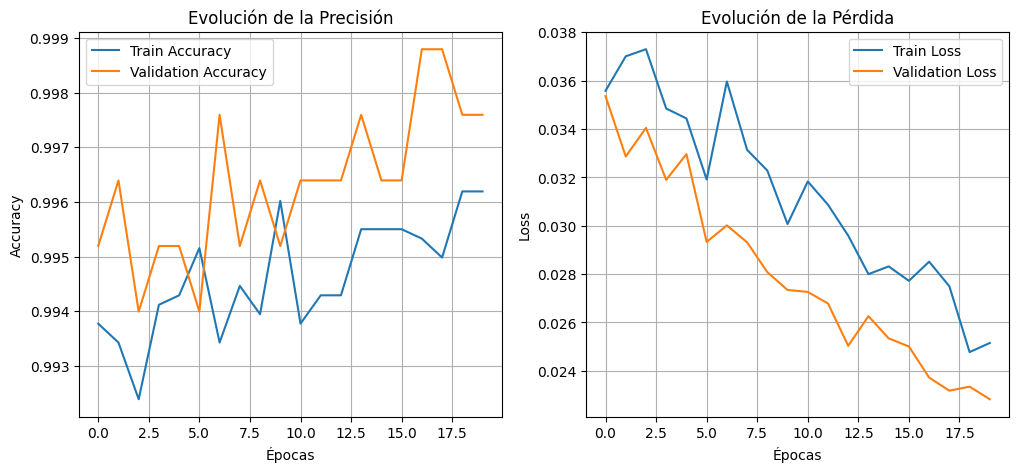

In [109]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['validation_acc'], label='Validation Accuracy')
plt.title('Evolución de la Precisión')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['validation_loss'], label='Validation Loss')
plt.title('Evolución de la Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# Inferencia con dataset de test

## Cargamos el modelo

In [121]:
def cargar_modelo(ruta_archivo):
    print(f"Cargando modelo desde: {ruta_archivo}")
    
    # 1. DETECTAR DISPOSITIVO
    # Si tienes GPU la usa, si no, usa CPU automáticamente.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 2. CREAR EL ESQUELETO (Arquitectura)
    # Usamos weights=None porque cargaremos los nuestros propios.
    model = models.resnet50(weights=None)
    
    # 3. RECONSTRUIR LA CAPA FINAL (Idéntica al entrenamiento)
    # Tienes 3 clases: casco, mascarilla, nada.
    num_clases = 3 
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(num_ftrs, num_clases)
    )
    
    # 4. INYECTAR LOS PESOS (El archivo .pt)
    try:
        # map_location es vital para evitar errores si pasas de GPU a CPU
        state_dict = torch.load(ruta_archivo, map_location=device)
        model.load_state_dict(state_dict)
    except FileNotFoundError:
        print(f"❌ Error: No encuentro el archivo {ruta_archivo}")
        return None

    # 5. PREPARAR PARA INFERENCIA
    model.to(device)
    model.eval() # IMPORTANTE: Congela Dropout y BatchNorm
    
    print("✅ Modelo cargado correctamente en", device)
    return model

In [122]:
ruta_archivo = "modelo_conv.pt"
model_loaded = cargar_modelo(ruta_archivo)

Cargando modelo desde: modelo_conv.pt


C:\Users\Manuel\AppData\Local\Temp\ipykernel_23444\3835549761.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ruta_archivo, map_location=device)

✅ Modelo cargado correctamente en cuda


In [113]:
def visualizar_prediccion_aleatoria(model, dataset_test):
    # 1. Poner el modelo en modo evaluación (apaga Dropout, etc.)
    model.eval()
    
    # 2. Elegir una imagen al azar del dataset de TEST cargado
    # dataset_test es image_datasets['test'] que definimos arriba
    idx = random.randint(0, len(dataset_test) - 1)
    img_tensor, label_idx = dataset_test[idx]
    
    # Obtener la clase real
    clase_real = class_names[label_idx]
    
    # 3. Preparar la imagen para el modelo (añadir batch dimension)
    img_input = img_tensor.unsqueeze(0).to(device)
    
    # 4. Inferencia
    with torch.no_grad():
        outputs = model(img_input)
        probs = F.softmax(outputs, dim=1)[0] * 100 # Convertir a porcentajes
        confianza, pred_idx = torch.max(probs, 0)
    
    clase_predicha = class_names[pred_idx.item()]
    confianza_val = confianza.item()
    
    # 5. Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # A) Mostrar la imagen
    # Tenemos que "des-normalizar" para que se vean bien los colores
    # (Hacemos la inversa de: mean=[0.485...], std=[0.229...])
    img_display = img_tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1) # Asegurar rango 0-1
    
    ax1.imshow(img_display)
    ax1.axis('off')
    
    # Color del título: Verde si acierta, Rojo si falla
    color = 'green' if clase_real == clase_predicha else 'red'
    ax1.set_title(f"Real: {clase_real.upper()}\nPred: {clase_predicha.upper()}", 
                  color=color, fontsize=14, fontweight='bold')
    
    # B) Gráfico de barras con las probabilidades
    ax2.barh(class_names, probs.cpu().numpy(), color=['blue', 'orange', 'green'])
    ax2.set_xlim(0, 120)
    ax2.set_title("Confianza del Modelo (%)")
    ax2.set_xlabel("Probabilidad")
    
    # Añadir el número exacto en la barra
    for i, v in enumerate(probs.cpu().numpy()):
        ax2.text(v + 1, i, f"{v:.1f}%", va='center')

    plt.tight_layout()
    plt.show()

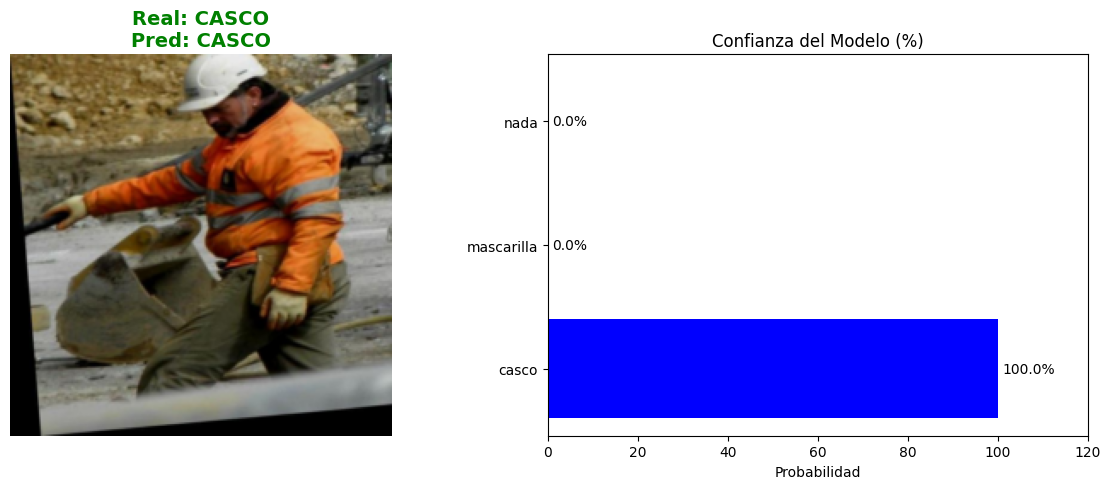

In [124]:
visualizar_prediccion_aleatoria(model_loaded, image_datasets['test'])